In [16]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn import metrics

In [17]:
lego_df = pd.read_csv('./data/lego_df.csv')

Imputación predicción valor con una red neuronal

In [38]:
"""import datawig
df_train, df_test = datawig.utils.random_split(lego_df)
parent_id = lego_df.parent_id.apply(str)
type(parent_id)
#Initialize a SimpleImputer model
imputer = datawig.SimpleImputer(
    input_columns=lego_df.columns, # column(s) containing information about the column we want to impute
    output_column= 'parent_id', # the column we'd like to impute values for
    output_path = 'imputer_model' # stores model data and metrics
    )
#Fit an imputer model on the train data
#imputer.fit(train_df=df_train)

#Impute missing values and return original dataframe with predictions
imputed = imputer.predict(df_test)"""

In [18]:
#Imputación most_frequent
lego_most_common_imputed = lego_df.apply(lambda x: x.fillna(x.value_counts().index[0]))
lego_most_common_imputed.isna().sum()

set_num        0
set_name       0
year           0
theme_id       0
num_parts      0
theme_name     0
parent_id      0
inv_id         0
inv_version    0
part_num       0
color_id       0
quantity       0
is_spare       0
color_name     0
rgb            0
is_trans       0
part_name      0
part_cat_id    0
dtype: int64

#### Encoding
Bag of words de las variables categóricas *is_spare*, *color_id* y *part_cat_id*: 
 
Cantidad de partes con color_id x, is_spare, part_cat_id utilizadas en cada set

In [19]:
is_spare_bow = lego_most_common_imputed.groupby(["set_num", "is_spare"]).quantity.sum().reset_index().pivot("set_num", "is_spare", "quantity").fillna(0)
is_spare_bow.columns = [f"is_spare_{c}" for c in is_spare_bow.columns]
is_spare_bow 

,is_spare_f,is_spare_t
set_num,,
00-1,471.0,0.0
00-2,147.0,0.0
00-3,149.0,0.0
00-4,126.0,0.0
0011-2,12.0,0.0
...,...,...
sw218promo-1,2.0,0.0
tech007promo-1,1.0,0.0
tf05-1,38.0,3.0


In [20]:
color_bow = lego_most_common_imputed.groupby(["set_num", "color_id"]).quantity.sum().reset_index().pivot("set_num", "color_id", "quantity").fillna(0)
color_bow.columns = [f"color_{c}" for c in color_bow.columns]
color_bow

,color_-1,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,...,color_383,color_450,color_462,color_484,color_503,color_1000,color_1002,color_1003,color_1006,color_9999
set_num,,,,,,,,,,,,,,,,,,,,,
00-1,0.0,8.0,30.0,0.0,0.0,72.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-2,0.0,71.0,2.0,2.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-3,0.0,26.0,28.0,1.0,0.0,65.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-4,0.0,16.0,8.0,2.0,0.0,48.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011-2,0.0,3.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sw218promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tech007promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
tf05-1,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Bag of words de part_cat_id-> cant de piezas de determinada part_cat_id utilizadas en cada set

part_bow = lego_most_common_imputed.groupby(["set_num", "part_cat_id"]).quantity.sum().reset_index().pivot("set_num", "part_cat_id", "quantity").fillna(0)
part_bow.columns = [f"part_{c}" for c in part_bow.columns]
part_bow

,part_1.0,part_2.0,part_3.0,part_4.0,part_5.0,part_6.0,part_7.0,part_8.0,part_9.0,part_10.0,...,part_48.0,part_49.0,part_50.0,part_51.0,part_52.0,part_53.0,part_54.0,part_55.0,part_56.0,part_57.0
set_num,,,,,,,,,,,,,,,,,,,,,
00-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-2,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-3,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-4,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sw218promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
tech007promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tf05-1,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Matriz X. Group by set_num y agrego variables de entrada. Merge de bag of words de part_num y color_id

X = (
    lego_most_common_imputed.groupby("set_num").agg({
        "inv_id": "nunique",
        "color_id": "nunique",
        "parent_id": "min",
        "part_num": "nunique",
        "year": "min"
    })
    .rename(
        columns=dict(part_num="n_parts", inv_id="n_invs", color_id="n_colors")
    )
    .merge(color_bow, left_index=True, right_index=True)   
    .merge(part_bow, left_index=True, right_index=True)
    .merge(is_spare_bow, left_index=True, right_index=True)
)

X.head(10)

,n_invs,n_colors,parent_id,n_parts,year,color_-1,color_0,color_1,color_2,color_3,...,part_50.0,part_51.0,part_52.0,part_53.0,part_54.0,part_55.0,part_56.0,part_57.0,is_spare_f,is_spare_t
set_num,,,,,,,,,,,,,,,,,,,,,
00-1,1,6,411.0,26,1970,0.0,8.0,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,471.0,0.0
00-2,1,7,411.0,38,1976,0.0,71.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147.0,0.0
00-3,1,6,411.0,31,1976,0.0,26.0,28.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,0.0
00-4,1,6,411.0,39,1976,0.0,16.0,8.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,0.0
0011-2,1,5,67.0,8,1978,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0012-1,1,3,126.0,6,1979,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0013-1,1,3,126.0,6,1979,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0014-1,1,2,126.0,6,1979,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0015-1,1,4,126.0,8,1979,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0


In [23]:
y = X.pop("parent_id")

#### Train test split

In [24]:
train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(validation_ratio+test_ratio), random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                train_size=(validation_ratio/
                                                           (validation_ratio+test_ratio)), random_state=42) 

print("Train: ", X_train.shape,y_train.shape)
print("Val: ",X_val.shape,y_val.shape)
print("Test:", X_test.shape,y_test.shape)

Train:  (7499, 182) (7499,)
Val:  (2142, 182) (2142,)
Test: (1072, 182) (1072,)


#### Train baseline model
1. Logistic regression

In [25]:
lr = LogisticRegression(random_state=42, multi_class="auto", max_iter=50).fit(X_train, y_train)

/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
y_pred_lr =lr.predict(X_test)

In [27]:
def metrics_report(y_test, y_pred):
    print('f1 score', metrics.f1_score(y_test, y_pred, average='weighted'))
    print('precision', metrics.precision_score(y_test, y_pred, average='weighted'))
    print('recall', metrics.recall_score(y_test, y_pred, average='weighted'))
    print('accuracy', metrics.accuracy_score(y_test, y_pred))

    return

In [28]:
print("Logistic regression")
print()
metrics_report(y_test, y_pred_lr)

Logistic regression

f1 score 0.2514348219689565
precision 0.247602837359047
recall 0.39365671641791045
accuracy 0.39365671641791045


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Decision tree clasifier

In [29]:
# Decision tree classifier
dt = DecisionTreeClassifier(max_depth=10, criterion='entropy')
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [33]:
# Decision tree classifier
dt_20 = DecisionTreeClassifier(max_depth=20, criterion='entropy')
dt_20.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20)

In [34]:
y_pred_dt = dt.predict(X_test)
y_pred_dt_20 = dt_20.predict(X_test)

In [35]:
print("Decision tree max depth 10", metrics_report(y_test, y_pred_dt))
print()
print("Decision tree max depth 20", metrics_report(y_test, y_pred_dt_20))

f1 score 0.6161589690268584
precision 0.623601519211387
recall 0.6315298507462687
accuracy 0.6315298507462687
Decision tree max depth 10 None

f1 score 0.6693092964217594
precision 0.673965624087827
recall 0.6744402985074627
accuracy 0.6744402985074627
Decision tree max depth 20 None


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
def feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title("Top 10 features importantes")
    plt.show()
    return

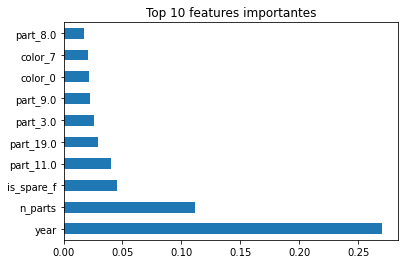

In [222]:
feature_importance(dt)

#### Random forest

In [37]:
#Train random forest
rf = RandomForestClassifier(n_estimators = 150, random_state=42) 
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [38]:
#Train random forest con max depth 10
rf_10 = RandomForestClassifier(n_estimators = 150, random_state=42, max_depth=10) 
rf_10.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)

In [39]:
y_pred_rf = rf.predict(X_test)
y_pred_rf_10 = rf_10.predict(X_test)

In [40]:
print("Random forest default max depth", metrics_report(y_test, y_pred_rf))
print()
print("Random forest  max depth = 10", metrics_report(y_test, y_pred_rf_10))



f1 score 0.7159938475203613
precision 0.7524681055563477
recall 0.75
accuracy 0.75
Random forest default max depth None

f1 score 0.485264905374718
precision 0.5923797418601233
recall 0.5718283582089553
accuracy 0.5718283582089553
Random forest  max depth = 10 None


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


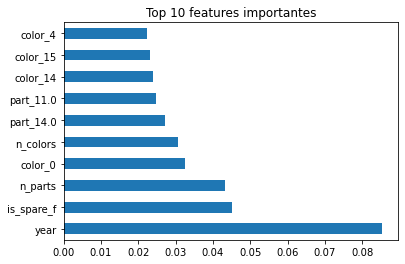

In [41]:
feature_importance(rf)

### Balanceo de clases

In [43]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [44]:
ros = RandomOverSampler(random_state=777)
x_ros, y_ros = ros.fit_resample(X_train, y_train)

In [45]:
X_train.shape

(7499, 182)

In [196]:
x_ros.shape

(190624, 182)

In [46]:
y_test.shape

(1072,)

In [47]:
rf_os = RandomForestClassifier(n_estimators = 150, random_state=42, max_depth=10)
rf_os.fit(x_ros, y_ros)

RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)

In [48]:
y_pred_rf_os = rf_os.predict(X_test)

In [49]:
metrics_report(y_test, y_pred_rf_os)

f1 score 0.4551989471934558
precision 0.6836403617178348
recall 0.45802238805970147
accuracy 0.45802238805970147


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
dt_os = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=42)
dt_os.fit(x_ros, y_ros)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

In [51]:
y_pred_dt_os = dt_os.predict(X_test)

In [52]:
metrics_report(y_test, y_pred_dt_os)

f1 score 0.42791314563931393
precision 0.5991630727508579
recall 0.42257462686567165
accuracy 0.42257462686567165


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
#logistic con oversampling
#lr = LogisticRegression(random_state=42, multi_class="auto", max_iter=100).fit(x_ros, y_ros)

In [ ]:
#y_pred_lr_os = lr.predict(X_test)

In [ ]:
#metrics_report(y_test, y_pred_lr_os)

f1 score 0.15813094047858153
precision 0.401618765055247
recall 0.1707089552238806
accuracy 0.1707089552238806


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Mantener rows con observaciones de theme_id > n en el dataset

In [55]:
v = lego_df.parent_id.value_counts()

In [56]:
sample_lego = lego_df[lego_df.parent_id.isin(v.index[v.gt(300)])]

In [58]:
print(sample_lego.shape)
print(lego_df.shape)

(370565, 18)
(580069, 18)


In [59]:
#Imputación most_frequent
sample_imputed = sample_lego.apply(lambda x: x.fillna(x.value_counts().index[0]))
sample_imputed.isna().sum()

set_num        0
set_name       0
year           0
theme_id       0
num_parts      0
theme_name     0
parent_id      0
inv_id         0
inv_version    0
part_num       0
color_id       0
quantity       0
is_spare       0
color_name     0
rgb            0
is_trans       0
part_name      0
part_cat_id    0
dtype: int64

In [60]:
color_bow = sample_imputed.groupby(["set_num", "color_id"]).quantity.sum().reset_index().pivot("set_num", "color_id", "quantity").fillna(0)
color_bow.columns = [f"color_{c}" for c in color_bow.columns]
color_bow

,color_-1,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,...,color_366,color_378,color_379,color_383,color_450,color_462,color_484,color_503,color_1000,color_9999
set_num,,,,,,,,,,,,,,,,,,,,,
00-1,0.0,8.0,30.0,0.0,0.0,72.0,0.0,0.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-2,0.0,71.0,2.0,2.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-3,0.0,26.0,28.0,1.0,0.0,65.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-4,0.0,16.0,8.0,2.0,0.0,48.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011-2,0.0,3.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sw117promo-1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
sw218promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tech007promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:
# Bag of words de part_cat_id-> cant de piezas de determinada part_cat_id utilizadas en cada set

part_bow = sample_imputed.groupby(["set_num", "part_cat_id"]).quantity.sum().reset_index().pivot("set_num", "part_cat_id", "quantity").fillna(0)
part_bow.columns = [f"part_{c}" for c in part_bow.columns]
part_bow

,part_1.0,part_2.0,part_3.0,part_4.0,part_5.0,part_6.0,part_7.0,part_8.0,part_9.0,part_10.0,...,part_48.0,part_49.0,part_50.0,part_51.0,part_52.0,part_53.0,part_54.0,part_55.0,part_56.0,part_57.0
set_num,,,,,,,,,,,,,,,,,,,,,
00-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-2,0.0,0.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-3,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00-4,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0011-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sw117promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sw218promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
tech007promo-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
is_spare_bow = sample_imputed.groupby(["set_num", "is_spare"]).quantity.sum().reset_index().pivot("set_num", "is_spare", "quantity").fillna(0)
is_spare_bow.columns = [f"is_spare_{c}" for c in is_spare_bow.columns]
is_spare_bow 

,is_spare_f,is_spare_t
set_num,,
00-1,471.0,0.0
00-2,147.0,0.0
00-3,149.0,0.0
00-4,126.0,0.0
0011-2,12.0,0.0
...,...,...
sw117promo-1,2.0,0.0
sw218promo-1,2.0,0.0
tech007promo-1,1.0,0.0


In [63]:

X = (
    sample_imputed.groupby("set_num").agg({
        "inv_id": "nunique",
        "color_id": "nunique",
        "parent_id": "min",
        "part_num": "nunique",
        "year": "min"
    })
    .rename(
        columns=dict(part_num="n_parts", inv_id="n_invs", color_id="n_colors")
    )
    .merge(color_bow, left_index=True, right_index=True)   
    .merge(part_bow, left_index=True, right_index=True)
    .merge(is_spare_bow, left_index=True, right_index=True)
)

X.head(10)

,n_invs,n_colors,parent_id,n_parts,year,color_-1,color_0,color_1,color_2,color_3,...,part_50.0,part_51.0,part_52.0,part_53.0,part_54.0,part_55.0,part_56.0,part_57.0,is_spare_f,is_spare_t
set_num,,,,,,,,,,,,,,,,,,,,,
00-1,1,6,411.0,26,1970,0.0,8.0,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,471.0,0.0
00-2,1,7,411.0,38,1976,0.0,71.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,147.0,0.0
00-3,1,6,411.0,31,1976,0.0,26.0,28.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,149.0,0.0
00-4,1,6,411.0,39,1976,0.0,16.0,8.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,0.0
0011-2,1,5,67.0,8,1978,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0012-1,1,3,126.0,6,1979,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0013-1,1,3,126.0,6,1979,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0014-1,1,2,126.0,6,1979,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
0015-1,1,4,126.0,8,1979,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0


In [64]:
X.shape

(7198, 179)

In [65]:
y = X.pop("parent_id")

In [66]:

train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(validation_ratio+test_ratio))
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                train_size=(validation_ratio/
                                                           (validation_ratio+test_ratio))) 

print("Train: ", X_train.shape,y_train.shape)
print("Val: ",X_val.shape,y_val.shape)
print("Test:", X_test.shape,y_test.shape)

Train:  (5038, 178) (5038,)
Val:  (1440, 178) (1440,)
Test: (720, 178) (720,)


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='parent_id', ylabel='count'>

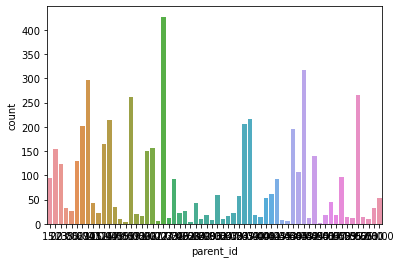

In [67]:
import seaborn as sns
sns.countplot(y_train)


In [71]:
#Train random forest
rf_si = RandomForestClassifier(n_estimators = 150, random_state=42) 
rf_si.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [75]:
y_pred_rf_si = rf_si.predict(X_test)


In [76]:
metrics_report(y_test, y_pred_rf_si)

f1 score 0.80573037193901
precision 0.8332567729617515
recall 0.8222222222222222
accuracy 0.8222222222222222


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
dt_si = DecisionTreeClassifier(max_depth=20, criterion='entropy')
dt_si.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20)

In [78]:
y_pred_dt_si =  dt_si.predict(X_test)

In [79]:
metrics_report(y_test, y_pred_dt_si)

f1 score 0.6635706146403645
precision 0.6783801262915818
recall 0.6666666666666666
accuracy 0.6666666666666666


/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mtaglio/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Variable importance

### Notas
* Outliers: al utilizar un modelo basado en árboles que es robusto a los outliers no los quitamos del train set.
* Probar con otros algoritmos (ej: xgboost)
* Hacer model selection con grid search